In [1]:
import pandas as pd
import numpy as np
from scipy import  stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csc_matrix, hstack
from sklearn.model_selection import cross_validate, train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict
from matplotlib_venn import venn2

In [14]:
class FeatureSelector():
    def __init__(self, estimator, metric, cv, use_values, use_recursion, fill_na, show_progress):
        self.estimator = estimator
        self.metric = metric
        self.cv = cv
        self.use_values = use_values        
        self.use_recursion = use_recursion
        self.show_progress = show_progress
        self.fill_na = fill_na
    def fit(self, X, Y):        
        flag = isinstance(X[:, 0], csc_matrix)
        # список с результатами валидации
        column_value_score = []
        # проходим по признакам
        for i in tqdm_notebook(range(X.shape[1])):
            # если формат матрицы признаков == csc_matrix
            if flag:
                # выбираем столбец, преобразуем
                ser = pd.DataFrame(X[:, i].todense())[0].values.flatten()
            # если формат != csc_matrix
            else:
                # выбираем столбец
                ser = X[:, i]        
            # если столбец в списке с проверкой значений 
            if self.use_values is not None:                
                if i in self.use_values:
                    # уникальные значения столбца
                    unique_values = np.unique(ser)  
                    # валидируем каждое значение
                    for val in unique_values:
                        _x = np.int32(ser==val).reshape(-1,1)
                        column_value_score.append((i, val,\
                                                   cross_val_score(self.estimator,\
                                                                   _x, Y,\
                                                                   scoring = self.metric,\
                                                                   cv = self.cv).mean()))
                else: 
                    # валидируем столбец
                    column_value_score.append((i, None,\
                                               cross_val_score(self.estimator,\
                                                               _x, Y,\
                                                               scoring = self.metric,\
                                                               cv = self.cv).mean()))
            else:
                # валидируем столбец
                    column_value_score.append((i, None,\
                                               cross_val_score(self.estimator,\
                                                               ser.reshape(-1,1), Y,\
                                                               scoring = self.metric,\
                                                               cv = self.cv).mean()))
                

        # признаки и значения признаков в порядке убывания валидации
        order = np.array(sorted(column_value_score, key = lambda x: x[-1], reverse = True))[:, :2]             
        # список лучших признаков
        best_features = []
        # словарь лучших значений признаков
        D_best_features = defaultdict(list)
        # список с признаками, не давшими прироста
        to_drop = []
        # лучшее значение метрики
        best_score = 0
        # проходим по признакам и значениям признаков в порядке убывания валидации
        for feature, feature_value in tqdm_notebook(order):   

            # добавляем текущие признаки/значения
            if feature_value is None:
                best_features.append(feature)               
            else:
                D_best_features[feature].append(feature_value)

            # обновляем матрицы
            L = []
            for k, v in D_best_features.items():
                if isinstance(X[:, k], csc_matrix):
                    L.append(pd.DataFrame(X[:, k].tocsc().todense())[0].apply(lambda x: x if x in v else self.fill_na))
                else:
                    L.append(pd.Series(X[:, k].flatten()).apply(lambda x: x if x in v else self.fill_na))

            if flag:
                if (len(best_features)>0) & (len(L)>0):
                    _X = csc_matrix(hstack([X[:, best_features], csc_matrix(np.column_stack(L)) ]))
                elif (len(best_features)==0) & (len(L)>0):
                    _X = csc_matrix(np.column_stack(L))
                elif (len(best_features)>0) & (len(L)==0):
                    _X = csc_matrix(X[:, best_features])                    
                        
            else:
                if (len(best_features)>0) & (len(L)>0):
                    _X = np.column_stack([X[:, best_features], np.column_stack(L)])
                elif (len(best_features)==0) & (len(L)>0):
                    _X = np.column_stack(L)
                elif (len(best_features)>0) & (len(L)==0):
                    _X = X[:, best_features] 
            # считаем валидацию    
            current_score = cross_val_score(self.estimator, _X, Y, scoring = self.metric, cv = self.cv).mean()
            # если метрика улучшилась
            if current_score>best_score:
                # обновляем лучшую метрику
                best_score = current_score
                # печатаем 
                if self.show_progress:
                    print('new best_score = {}'.format(best_score))
            # если метрика не улучшилась
            else: 
                # удаляем признак/значение
                if feature_value is None:
                    best_features = [val for val in best_features if val != feature]
                    to_drop.append((feature, None))
                else:
                    D_best_features[feature] = [val for val in D_best_features[feature] if val != feature_value]    
                    to_drop.append((feature, feature_value))



        if self.use_recursion:
            # запускаем бесконечный цикл
            while True:
                # списки лучших признаков до и после
                to_drop_before = to_drop
                to_drop_after = []
                # проходим по признакам и значениям признаков в порядке убывания валидации
                for feature, feature_value in tqdm_notebook(to_drop_before):   
                    # добавляем текущие признаки/значения
                    if feature_value is None:
                        best_features.append(feature)               
                    else:
                        D_best_features[feature].append(feature_value)

                    # обновляем матрицы
                    L = []
                    for k, v in D_best_features.items():
                        if isinstance(X[:, k], csc_matrix):
                            L.append(pd.DataFrame(X[:, k].tocsc().todense())[0].apply(lambda x: x if x in v else self.fill_na))
                        else:
                            L.append(pd.Series(X[:, k].flatten()).apply(lambda x: x if x in v else self.fill_na))

                    if flag:
                        _X = csc_matrix(hstack([X[:, best_features], csc_matrix(np.column_stack(L)) ]))
                    else:
                        _X = np.column_stack([X[:, best_features], np.column_stack(L)])

                    # считаем валидацию    
                    current_score = cross_val_score(self.estimator, _X, Y, scoring = self.metric, cv = self.cv).mean()
                    # если метрика улучшилась
                    if current_score>best_score:
                        # обновляем лучшую метрику
                        best_score = current_score
                        # печатаем 
                        if self.show_progress:
                            print('new best_score = {}'.format(best_score))
                    # если метрика не улучшилась
                    else: 
                        # удаляем признак/значение
                        if feature_value is None:
                            best_features = [val for val in best_features if val != feature]
                            to_drop_after.append((feature, None))
                        else:
                            D_best_features[feature] = [val for val in D_best_features[feature] if val != feature_value]    
                            to_drop_after.append((feature, feature_value))

                # если списки одинаковые, останавливаем отбор
                if len(to_drop_after) == len(to_drop_before):
                    break
                # если разные - обновляем списки до и после
                else:
                    to_drop_before = to_drop_after
                    to_drop_after = []
                    
        self.best_features = best_features
        self.D_best_features = D_best_features
        self.best_score =best_score
        self.flag = flag
    def transform(self, X):
              
        if len(self.best_features) !=0:
            x1 = X[:, self.best_features]
        else:
            x1 = None
        if len(list(self.D_best_features.keys())) !=0:
            L=[]
            for k, v in self.D_best_features.items():
                if self.flag:
                    L.append(pd.DataFrame(X[:, k].tocsc().todense())[0].apply(lambda x: x if x in v else self.fill_na))                    
                else:
                    L.append(pd.Series(X[:, k].flatten()).apply(lambda x: x if x in v else self.fill_na))
            x2 = np.column_stack(L)
        else:
            x2 = None
            
        if (x1 is not None) & (x2 is not None):
            if self.flag: 
                _X = csc_matrix(hstack([x1, x2]))
            else:
                _X = np.column_stack([x1, x2])
                
        if (x1 is not None) & (x2 is None):
            _X = x1
        if (x1 is None) & (x2 is not None):
            if self.flag:
                _X = csc_matrix(x2)
            else:
                _X = x2
        return _X     
        
    def return_self(self):
        return self
    
            
            
            

In [15]:
times = ['time%d' % i for i in range(1, 11)]
sites = ['site%d' % i for i in range(1, 11)]
SEED = 13

df_tr = pd.read_csv('train_sessions.csv', parse_dates = times).set_index('session_id').sort_values('time1')
df_te = pd.read_csv('test_sessions.csv', parse_dates = times).set_index('session_id')
y_tr = df_tr['target']

дата = 201301, появлений Элис = 0
дата = 201302, появлений Элис = 61
дата = 201303, появлений Элис = 0
дата = 201304, появлений Элис = 38
дата = 201305, появлений Элис = 0
дата = 201306, появлений Элис = 0
дата = 201307, появлений Элис = 0
дата = 201308, появлений Элис = 0
дата = 201309, появлений Элис = 377
дата = 201310, появлений Элис = 0
дата = 201311, появлений Элис = 446
дата = 201312, появлений Элис = 134
дата = 201401, появлений Элис = 129
дата = 201402, появлений Элис = 410
дата = 201403, появлений Элис = 400
дата = 201404, появлений Элис = 302


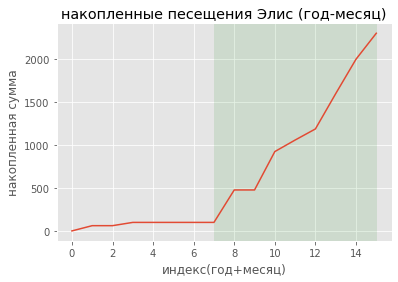

In [16]:
df_tr['ym'] = df_tr['time1'].dt.year*100+df_tr['time1'].dt.month
target_by_ym = df_tr.groupby('ym')['target'].sum()
for _ym, _total_alice in target_by_ym.items():
    print('дата = {}, появлений Элис = {}'.format(_ym, _total_alice))
    

target_by_ym.cumsum().reset_index(drop = True).plot()
plt.title('накопленные песещения Элис (год-месяц)')
plt.xlabel('индекс(год+месяц)')
plt.ylabel('накопленная сумма')
plt.axvspan(7, 15, color = 'green', alpha = .1)
plt.show()    


### актуальный период начинается после 201309, когда активность Элис возобновляется

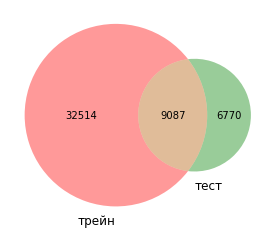

In [17]:
sites_unique_tr = pd.Series(df_tr[sites].values.flatten()).dropna().unique()
sites_unique_te = pd.Series(df_te[sites].values.flatten()).dropna().unique()

set_sites_tr = set(sites_unique_tr)
set_sites_te = set(sites_unique_te)

venn2([set_sites_tr, set_sites_te], ('трейн', 'тест'))

plt.show()

### оставим в трейне сайты, которые посещались Элис+присутствуют в тест части, чтобы не переобучаться на трейн

In [18]:
# оставляем в трейне сайты, которые были посещены Элис + присутствуют в тест части
sites_to_use = np.intersect1d(pd.Series(df_tr[sites][y_tr==1].values.flatten()).dropna().unique(),\
                              pd.Series(df_te[sites].values.flatten()).dropna().unique())
sites_tr = df_tr[sites].applymap(lambda x: x if x in sites_to_use else -1)

### дата: день года, неделя года, год, месяц, день, день недели, час(оставим данные из тест части)

In [19]:
D_ts = {}
for name, _df in zip(('train', 'test'), (df_tr, df_te)):
    start = _df[times].min(1).dt.round('H')
    
    D_ts[name] = pd.concat([start.dt.dayofyear,
                            start.dt.weekofyear,
                            start.dt.quarter,
                            start.dt.year,
                            start.dt.month,
                            start.dt.day,
                            start.dt.dayofweek,
                            start.dt.hour], 1)
    
for col in D_ts['test'].columns:
    values_to_use = D_ts['test'][col].dropna().unique()
    D_ts['train'][col] = D_ts['train'][col].apply(lambda x:x if x in values_to_use else -1)

In [20]:
# модели
logit_clf = LogisticRegression(random_state = SEED)
lgb_clf = LGBMClassifier(random_state = SEED)

# доля отложенной части
HOLDOUT_SHARE = .1
idx_split = np.int32(np.around(len(y_tr)*(1-HOLDOUT_SHARE)))

In [21]:
# время
_X_ts_tr = D_ts['train'].values
# ohe
encoder = OneHotEncoder(handle_unknown='ignore')
_X_ts_ohe_tr = csc_matrix(encoder.fit_transform(_X_ts_tr))
# сайты
_X_sites_tr = sites_tr
# таргет
_y_tr = np.array(y_tr)

### отберем признаки для разного числа фолдов (3-10) и разных моделей (logit, lgb)
* TfidfVectorizer(ngram_range = (1, 1), max_features = 100)
* ngram_range - используем комбинации длиной 1, 2
* max_features = используем топ 100 самых популярных признаков

используется ранняя остановка, так что найдутся далеко не самые оптимальные признаки

In [22]:
BASELINE_VECTORIZER = TfidfVectorizer(ngram_range = (1, 1), max_features = 100)
# трансформируем сайты
tfidf_full = BASELINE_VECTORIZER.fit_transform(pd.concat([sites_tr, df_te[sites]], 0)\
                                           .astype(str).apply(lambda x: '_'.join(x), axis = 1))
tfidf_tr = tfidf_full[:len(y_tr)]

_X_lgb_tr = csc_matrix(hstack([_X_ts_tr, tfidf_tr]))
_X_logit_tr = csc_matrix(hstack([_X_ts_ohe_tr, tfidf_tr])) 

NFOLDS_RANGE = np.arange(3, 11)

* отбираем признаки на валидации, тестируем отобранные признаки на отложенной выборке(которую модель не видела)
* используем разные схемы валидации
* выбираем те признаки, которые дали лучший auc на отложенной выборке

In [30]:
L_lgb = []
L_logit = []
for nfolds in tqdm_notebook(NFOLDS_RANGE):
    tscv = TimeSeriesSplit(nfolds)
    
    lgb_selector = FeatureSelector(estimator = lgb_clf,\
                               metric = 'roc_auc',\
                               cv = tscv,\
                               use_values = np.arange(_X_ts_tr.shape[1]).tolist(),\
                               use_recursion = False,\
                               fill_na = -1,\
                               show_progress = True)
    
    lgb_selector.fit(_X_lgb_tr[:idx_split], _y_tr[:idx_split])
    # лучший auc на валидации
    best_cv = lgb_selector.return_self().best_score    
    # отобранные признаки    
    lgb_clf.fit(_X_selected_tr[:idx_split], _y_tr[:idx_split])
    # auc на отложенной 
    auc_holdout = roc_auc_score(_y_tr[idx_split:], lgb_clf.predict_proba(_X_selected_tr[idx_split:])[:, 1])
    
    L_lgb.append((nfolds, best_cv, auc_holdout,\
                 (lgb_selector.return_self().best_features,\
                 lgb_selector.return_self().D_best_features)))
    
    logit_selector = FeatureSelector(estimator = logit_clf,\
                               metric = 'roc_auc',\
                               cv = tscv,\
                               use_values = None,\
                               use_recursion = False,\
                               fill_na = -1,\
                               show_progress = True)
    
    logit_selector.fit(_X_logit_tr[:idx_split], _y_tr[:idx_split])
    # лучший auc на валидации
    best_cv = logit_selector.return_self().best_score    
    # отобранные признаки
    _X_selected_tr = logit_selector.transform(_X_logit_tr)
    logit_clf.fit(_X_selected_tr[:idx_split], _y_tr[:idx_split])
    # auc на отложенной 
    auc_holdout = roc_auc_score(_y_tr[idx_split:], logit_clf.predict_proba(_X_selected_tr[idx_split:])[:, 1])
    
    L_logit.append((nfolds, best_cv, auc_holdout,\
                 (logit_selector.return_self().best_features,\
                 logit_selector.return_self().D_best_features)))
    

new best_score = 0.6380714571760009
new best_score = 0.7548915740914087
new best_score = 0.7970640678886763
new best_score = 0.8235382674527684
new best_score = 0.8423313710136489
new best_score = 0.8637247671574776
new best_score = 0.8848632261828105
new best_score = 0.9000121583505275
new best_score = 0.9004368523318375
new best_score = 0.9013791871868949
new best_score = 0.9075604488470757
new best_score = 0.9131281672227036
new best_score = 0.9160811887394001
new best_score = 0.91708485334979
new best_score = 0.9212062965565645
new best_score = 0.9212246995307417
new best_score = 0.921252843626544
new best_score = 0.921271267131308
new best_score = 0.9311937931618809
new best_score = 0.9316713364834134
new best_score = 0.9318700467289234
new best_score = 0.9331052805100937
new best_score = 0.9344867327267347
new best_score = 0.9363918490721468
new best_score = 0.9378206297985611
new best_score = 0.9386880655612968



new best_score = 0.8232574472033137
new best_score = 0.8325931139904655
new best_score = 0.8528561521110766
new best_score = 0.8826936335848159
new best_score = 0.9005400128776514
new best_score = 0.9095277608890066
new best_score = 0.9148199308791165
new best_score = 0.9181582601067397
new best_score = 0.926558281024043
new best_score = 0.9313964878397206
new best_score = 0.9412145309834301
new best_score = 0.9412790931116546
new best_score = 0.942102857554611
new best_score = 0.9421911000115221
new best_score = 0.9422711446361819
new best_score = 0.9425380658726693
new best_score = 0.9427804616963268
new best_score = 0.9430850318127532
new best_score = 0.9430942866999543
new best_score = 0.9440492563079061
new best_score = 0.9461203637296816
new best_score = 0.9495146781229776
new best_score = 0.9503145962234992
new best_score = 0.9503981174569613
new best_score = 0.9508334230205344
new best_score = 0.9520081592713129
new best_score = 0.9521752734380318
new best_score = 0.95287625262

new best_score = 0.632848627669736
new best_score = 0.7133791977913879
new best_score = 0.7814928998427
new best_score = 0.8091293571082608
new best_score = 0.8588551227309785
new best_score = 0.8656242920624592
new best_score = 0.883201715019818
new best_score = 0.8902765454747409
new best_score = 0.8907145945164536
new best_score = 0.8953832590444091
new best_score = 0.8963070835778517
new best_score = 0.9008254084226875
new best_score = 0.9052156510561666
new best_score = 0.9074311307038898
new best_score = 0.9091354074466503
new best_score = 0.9158075266690111
new best_score = 0.9160719238754749
new best_score = 0.9173616286318784
new best_score = 0.9178897975032647
new best_score = 0.942513512219334
new best_score = 0.9435661909759329
new best_score = 0.9438548647393068
new best_score = 0.9445907976042216
new best_score = 0.9445926883092137
new best_score = 0.947400565981479
new best_score = 0.9474264233888623
new best_score = 0.9482525306107743
new best_score = 0.9488501631045023

new best_score = 0.8333830062935954
new best_score = 0.8431268166776111
new best_score = 0.860300287835563
new best_score = 0.8845231261231663
new best_score = 0.8882231809178469
new best_score = 0.9058439056461962
new best_score = 0.9099861524928108
new best_score = 0.9178458894997278
new best_score = 0.927447929572822
new best_score = 0.9286849976588168
new best_score = 0.9345882778140995
new best_score = 0.9348949913864723
new best_score = 0.9364567368359252
new best_score = 0.9372613547483847
new best_score = 0.943625689977132
new best_score = 0.9440697447409729
new best_score = 0.9441545310018896
new best_score = 0.9443496391937869
new best_score = 0.9462383563401879
new best_score = 0.9493527227497841
new best_score = 0.9502230687086102
new best_score = 0.9503502823841463
new best_score = 0.9507561052603823
new best_score = 0.9508714363556974
new best_score = 0.9514134567983277
new best_score = 0.9515850651419732
new best_score = 0.9520952951019596
new best_score = 0.952778225659

new best_score = 0.6128920424700828
new best_score = 0.6891616265005271
new best_score = 0.69619561892985
new best_score = 0.7632460358156574
new best_score = 0.7929874321203574
new best_score = 0.8045101306584144
new best_score = 0.83897421402506
new best_score = 0.838990200279486
new best_score = 0.8650725853450847
new best_score = 0.8773383926685892
new best_score = 0.8821772795617939
new best_score = 0.8844301135356915
new best_score = 0.8891805084810178
new best_score = 0.8927356850614867
new best_score = 0.8945396074321514
new best_score = 0.8948527735705196
new best_score = 0.8977184703352805
new best_score = 0.9386925387289283
new best_score = 0.9387106577066391
new best_score = 0.9391909835190233
new best_score = 0.9398932427238332
new best_score = 0.9404816631367845
new best_score = 0.942626037289959
new best_score = 0.9427404560955672
new best_score = 0.9429736605318452
new best_score = 0.9449801689760762
new best_score = 0.9450833069006187
new best_score = 0.945412852914505

new best_score = 0.8139502140618682
new best_score = 0.8271823444638015
new best_score = 0.8595165788316868
new best_score = 0.8776682708342051
new best_score = 0.8818928518365052
new best_score = 0.8884611100354561
new best_score = 0.8941552839486034
new best_score = 0.9039886386931111
new best_score = 0.9061283142870952
new best_score = 0.9172229060396088
new best_score = 0.9188623972875807
new best_score = 0.9192765408553951
new best_score = 0.9196807324910017
new best_score = 0.9217276437502349
new best_score = 0.9262758348189184
new best_score = 0.9294028140913699
new best_score = 0.9328903100086059
new best_score = 0.933649864709485
new best_score = 0.9347445672041006
new best_score = 0.935683184787228
new best_score = 0.9361425134983984
new best_score = 0.936206501880766
new best_score = 0.9371179382634359
new best_score = 0.9383812144737147
new best_score = 0.9386640839016318
new best_score = 0.9391308706042782
new best_score = 0.9393173263018376
new best_score = 0.939483389892

new best_score = 0.6196096385014045
new best_score = 0.6850812206880432
new best_score = 0.7493456012743289
new best_score = 0.7824494774374156
new best_score = 0.7978935258110539
new best_score = 0.8338577285873621
new best_score = 0.8466771838700303
new best_score = 0.8472023707020259
new best_score = 0.8536476343389032
new best_score = 0.8628284020157082
new best_score = 0.8666777284482801
new best_score = 0.8766597177002827
new best_score = 0.8797100363709783
new best_score = 0.8845155613934877
new best_score = 0.8981731073376545
new best_score = 0.9019330869589258
new best_score = 0.9049441005923614
new best_score = 0.9051144176577869
new best_score = 0.9053615076665188
new best_score = 0.9059953773484549
new best_score = 0.9064473894803325
new best_score = 0.9389284812383493
new best_score = 0.9402707418269678
new best_score = 0.9416103339315299
new best_score = 0.9431028373787629
new best_score = 0.9437275921390093
new best_score = 0.9439354081240893
new best_score = 0.944239796

new best_score = 0.8152110491172789
new best_score = 0.8320242422880234
new best_score = 0.8647268195307601
new best_score = 0.8720292936376186
new best_score = 0.8877860303717063
new best_score = 0.8984627810408347
new best_score = 0.9013011885078362
new best_score = 0.9039957812353179
new best_score = 0.9145119012348782
new best_score = 0.9158822926796252
new best_score = 0.9172042795206862
new best_score = 0.9214375256891216
new best_score = 0.9220667164265922
new best_score = 0.9232070335942747
new best_score = 0.9233087829847348
new best_score = 0.9265574046897922
new best_score = 0.9301202323507929
new best_score = 0.931112869852266
new best_score = 0.9360563426017258
new best_score = 0.9369907142352618
new best_score = 0.9374183958583022
new best_score = 0.9383140355517071
new best_score = 0.9385180351676584
new best_score = 0.9388158046657932
new best_score = 0.9389838383956883
new best_score = 0.9394802667459259
new best_score = 0.940414549634068
new best_score = 0.94164756989

new best_score = 0.615245195437962
new best_score = 0.628503584509655
new best_score = 0.6713555287608998
new best_score = 0.7614013089852908
new best_score = 0.7906234825357809
new best_score = 0.7922687305145569
new best_score = 0.8210866916903542
new best_score = 0.8752816985595337
new best_score = 0.8829138261243018
new best_score = 0.8859234630914382
new best_score = 0.8873747504689522
new best_score = 0.8907840978032704
new best_score = 0.8988198667997439
new best_score = 0.9041936907024286
new best_score = 0.9290851711580581
new best_score = 0.9293703836611874
new best_score = 0.9295390948888891
new best_score = 0.9306092257737127
new best_score = 0.9308589070590197
new best_score = 0.931992396639058
new best_score = 0.9320935645909277
new best_score = 0.9325535572262229
new best_score = 0.9355106195157268
new best_score = 0.9380995180451216
new best_score = 0.9393519458183437
new best_score = 0.9398425340693122
new best_score = 0.94728540222031



new best_score = 0.821160825602407
new best_score = 0.8298748403787533
new best_score = 0.839313994285276
new best_score = 0.8516495968507797
new best_score = 0.8635483232875004
new best_score = 0.8904638272571207
new best_score = 0.9001138383252323
new best_score = 0.9027922244524184
new best_score = 0.9129497288088826
new best_score = 0.9158974597617154
new best_score = 0.9165366696355085
new best_score = 0.9167355976590635
new best_score = 0.919246307841158
new best_score = 0.9220317865678052
new best_score = 0.9230310944751194
new best_score = 0.92361852081393
new best_score = 0.9237286297695316
new best_score = 0.924156290729479
new best_score = 0.9267390040704863
new best_score = 0.9297794797545247
new best_score = 0.9316778564911645
new best_score = 0.9325671743463817
new best_score = 0.9329279757302718
new best_score = 0.9329504945199382
new best_score = 0.9336810774231487
new best_score = 0.9363685465125829
new best_score = 0.9371008783485858
new best_score = 0.938290967265597

new best_score = 0.6164016249861313
new best_score = 0.6622687172268685
new best_score = 0.7211027104491343
new best_score = 0.7574791283270459
new best_score = 0.7739865749072041
new best_score = 0.7785901509696007
new best_score = 0.8097908442707051
new best_score = 0.8103054181531404
new best_score = 0.8184328219780732
new best_score = 0.8220961931028856
new best_score = 0.8263492299469964
new best_score = 0.8291127693724452
new best_score = 0.8333387183494343
new best_score = 0.8358370344563375
new best_score = 0.8373426570982119
new best_score = 0.8422214739621221
new best_score = 0.8440351793106645
new best_score = 0.8445831249541215
new best_score = 0.8484418264479544
new best_score = 0.848596815539293
new best_score = 0.8488673933576781
new best_score = 0.8488924302541572
new best_score = 0.8705423522249264



new best_score = 0.8222413787537091
new best_score = 0.8330363716075176
new best_score = 0.8563310898482273
new best_score = 0.8586510022073485
new best_score = 0.8664427588320469
new best_score = 0.8759678934234543
new best_score = 0.8878977988915908
new best_score = 0.8911881528614953
new best_score = 0.9036890403459354
new best_score = 0.9057434150363133
new best_score = 0.906246327137479
new best_score = 0.9088734757254175
new best_score = 0.9110958058790399
new best_score = 0.9112033749472039
new best_score = 0.913675194286516
new best_score = 0.9172769373795412
new best_score = 0.9200172889741289
new best_score = 0.9233791835413742
new best_score = 0.9247322468774943
new best_score = 0.9251515440255146
new best_score = 0.9259144139759142
new best_score = 0.9261192127628236
new best_score = 0.9270620417426316
new best_score = 0.9293537119536595
new best_score = 0.9298264232277873
new best_score = 0.9298837735107113
new best_score = 0.9306792519523557
new best_score = 0.93179965381

new best_score = 0.6180545006033772
new best_score = 0.7173111845700065
new best_score = 0.7319145084613727
new best_score = 0.7368495199580952
new best_score = 0.7685484779335909
new best_score = 0.7854150980307408
new best_score = 0.8152324385363574
new best_score = 0.824554263227364
new best_score = 0.8252908273235519
new best_score = 0.8426722789092883
new best_score = 0.8506016934995397
new best_score = 0.8547432077326537
new best_score = 0.8610198835579921
new best_score = 0.8625487210767622
new best_score = 0.864515324470553
new best_score = 0.8646373402039278
new best_score = 0.8654074944967752
new best_score = 0.8664494808770148
new best_score = 0.8705293815814327
new best_score = 0.8744206007880777
new best_score = 0.8755650360799785
new best_score = 0.8773433624365649
new best_score = 0.8810553766824795
new best_score = 0.8818559130923574
new best_score = 0.8877373045217252
new best_score = 0.8879779742928613
new best_score = 0.9178812933544843
new best_score = 0.91852707970

new best_score = 0.8090461203008285
new best_score = 0.8241078521613328
new best_score = 0.851157623095613
new best_score = 0.8661434204609744
new best_score = 0.874414127830633
new best_score = 0.8745544087684338
new best_score = 0.8862740124198999
new best_score = 0.8891007014837773
new best_score = 0.9015083978923086
new best_score = 0.9039082886823206
new best_score = 0.9045531243490367
new best_score = 0.9046072293031949
new best_score = 0.9063145160408368
new best_score = 0.9075293707715983
new best_score = 0.9111367065717929
new best_score = 0.9142349265372144
new best_score = 0.914361229845091
new best_score = 0.9179827586029883
new best_score = 0.9190317079035386
new best_score = 0.9193229931997404
new best_score = 0.9194701216208541
new best_score = 0.9198492074418034
new best_score = 0.9201992699809731
new best_score = 0.9209785461844222
new best_score = 0.9225123934833539
new best_score = 0.9231280955187278
new best_score = 0.9232517692868514
new best_score = 0.925788571978

new best_score = 0.5963958188253057
new best_score = 0.6882626365079657
new best_score = 0.7167916494108573
new best_score = 0.753659061773167
new best_score = 0.7658434452703773
new best_score = 0.8073686589637855
new best_score = 0.8264736600155406
new best_score = 0.8276316772680312
new best_score = 0.832171440505712
new best_score = 0.8367245561838423
new best_score = 0.8449874751649771
new best_score = 0.856008441775564
new best_score = 0.8638345100921219
new best_score = 0.8677499926625034
new best_score = 0.8687538787284461
new best_score = 0.8701671378237616
new best_score = 0.8712703418151089
new best_score = 0.8959258917008303
new best_score = 0.8988542585028589
new best_score = 0.8995946120935701
new best_score = 0.9032449837947076
new best_score = 0.9033688793900645
new best_score = 0.9035259920068185
new best_score = 0.9036335352643935
new best_score = 0.905148323129145
new best_score = 0.9104422250173521
new best_score = 0.9104698253113377
new best_score = 0.9171037576327

new best_score = 0.8070094211483113
new best_score = 0.8226483808646219
new best_score = 0.8426807535934959
new best_score = 0.8558610712585484
new best_score = 0.8631544576598553
new best_score = 0.8675142825695682
new best_score = 0.8798113258232642
new best_score = 0.8832624971910127
new best_score = 0.897405568269644
new best_score = 0.8996195994168655
new best_score = 0.9073860930232989
new best_score = 0.9088711930570066
new best_score = 0.9089137386254398
new best_score = 0.9101318326931871
new best_score = 0.913981473470856
new best_score = 0.9166970530431546
new best_score = 0.9178553215066072
new best_score = 0.9217944373029221
new best_score = 0.9223867164273531
new best_score = 0.9231671434298176
new best_score = 0.9237211957338343
new best_score = 0.9239178135148135
new best_score = 0.924646566651073
new best_score = 0.925646842025273
new best_score = 0.9256469486954441
new best_score = 0.9262827375502176
new best_score = 0.9264315345984991
new best_score = 0.9267012447134

### если метрика на валидации сильно больше метрики на отложенной - переобучение на трейн датасет

In [53]:
print('{} | {} | {} | {} | {}'.format('nfolds', 'logit_cv', 'logit_holdout', 'lgb_cv', 'lgb_holdout'))
print('--------------------------------------------------------')
for i in range(len(L_lgb)):
    l1 = L_logit[i]
    l2 = L_lgb[i]
    print('{:>6} | {:<8.4f} | {:<13.4f} | {:.4f} | {:.4f}'.format(l1[0], l1[1], l1[2], l2[1], l2[2]))

nfolds | logit_cv | logit_holdout | lgb_cv | lgb_holdout
--------------------------------------------------------
     3 | 0.9610   | 0.9513        | 0.9387 | 0.7086
     4 | 0.9606   | 0.9652        | 0.9560 | 0.9239
     5 | 0.9479   | 0.9520        | 0.9538 | 0.9637
     6 | 0.9487   | 0.9314        | 0.9477 | 0.9441
     7 | 0.9498   | 0.9601        | 0.9473 | 0.8735
     8 | 0.9426   | 0.9420        | 0.8705 | 0.9533
     9 | 0.9368   | 0.9348        | 0.9185 | 0.9117
    10 | 0.9360   | 0.9333        | 0.9241 | 0.8836


In [ ]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, ParameterGrid

grid1 = {'max_depth' : np.arange(3, 11, 2).tolist(),\
        'num_leaves' : [2**i for i in range(2, 7)],\
        'min_child_samples' : [50, 100, 300],\
        'n_estimators' : [500], 'learning_rate' :[.03, .05, .1],
        'subsample' : [.5, .7, 1], 'colsample_bytree' : [.5, .7, 1]}
#         'reg_alpha' :[0, 2, 5], 'reg_lambda' :[0, 2, 5] }

best_score = .5
for params in tqdm_notebook(ParameterGrid(grid1)):  
    est = LGBMClassifier(**params)
    est.fit(xtr, ytr, eval_set=[(xtr, ytr), (xval, yval)],\
            eval_metric='auc', early_stopping_rounds=30, verbose = 0)
    score = roc_auc_score(yval, est.predict_proba(xval)[:, 1])
    if score > best_score:
        best_score = score
        best_params = params